FOR THE DATASET, VISIT:
https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**PREPROCESSING DATASET**

In [3]:
ROOT = '/kaggle/input/satellite-image-classification/data'
img_paths = []
labels = []
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(ROOT)))
}

In [4]:
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(ROOT, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)    

**SPLIT DATASET FOR TRAIN/VAL/TEST**

In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

# For training dataset
X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size = val_size,
    random_state = seed,
    shuffle = is_shuffle
)

# For testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size = test_size,
    random_state = seed, shuffle = is_shuffle
)

**CREATE PYTORCH DATASETS**

In [6]:
class ImageCls(nn.Module):
    def __init__(self, X, y, transform = None):
        self.transform = transform
        self.img_paths = X
        self.labels = y
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

**NORMALIZE THE INPUTS**

In [7]:
def transform(img, img_size = (224,224)):
    # To make sure every image has the same size
    img = img.resize(img_size)
    
    # We just consider RGB color of the image
    img = np.array(img)[..., :3]
    
    # Convert image from (height, width, channel) to (channel, height, width)
    # After that, convert to float type for using torch
    img = torch.tensor(img).permute(2,0,1).float()

    # Normalize the image
    normalized_img = img/255.0
    return normalized_img

**CREATE DATALOADER**

In [8]:
train_dataset = ImageCls(
    X_train, y_train,
    transform = transform
)

val_dataset = ImageCls(
    X_val, y_val,
    transform = transform
)

test_dataset = ImageCls(
    X_test, y_test,
    transform = transform
)

In [9]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


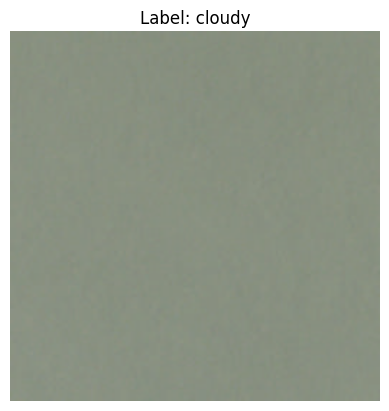

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

**MODEL - RESNET**

In [11]:
# In this problem, we implement the custom ResNet model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        
        return x

In [12]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding = 3
        )
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(
            kernel_size = 3, stride = 2, padding = 1
        )
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride = 1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc_1(x)

        return x

In [13]:
n_classes = len(list(classes.keys()))

# We choose the ResNet-18 for this image classification problem 
# For ResNet-34, we choose n_block_lst = [3, 4, 6, 3]
model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [14]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 4])


In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [17]:
lr = 1e-2
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 0.5614	Val loss: 1.4305
EPOCH 2:	Train loss: 0.2884	Val loss: 1.5749
EPOCH 3:	Train loss: 0.2039	Val loss: 1.4828
EPOCH 4:	Train loss: 0.1690	Val loss: 1.4942
EPOCH 5:	Train loss: 0.1713	Val loss: 1.4218
EPOCH 6:	Train loss: 0.2958	Val loss: 0.5980
EPOCH 7:	Train loss: 0.1465	Val loss: 0.3618
EPOCH 8:	Train loss: 0.1717	Val loss: 0.3493
EPOCH 9:	Train loss: 0.1211	Val loss: 1.8387
EPOCH 10:	Train loss: 0.1335	Val loss: 1.2533
EPOCH 11:	Train loss: 0.1415	Val loss: 1.0356
EPOCH 12:	Train loss: 0.1198	Val loss: 0.9787
EPOCH 13:	Train loss: 0.1950	Val loss: 1.3564
EPOCH 14:	Train loss: 0.1433	Val loss: 0.8711
EPOCH 15:	Train loss: 0.1231	Val loss: 1.1385
EPOCH 16:	Train loss: 0.0831	Val loss: 0.2891
EPOCH 17:	Train loss: 0.0923	Val loss: 0.6873
EPOCH 18:	Train loss: 0.0683	Val loss: 1.4680
EPOCH 19:	Train loss: 0.0603	Val loss: 0.2049
EPOCH 20:	Train loss: 0.0486	Val loss: 0.3087
EPOCH 21:	Train loss: 0.0904	Val loss: 0.7698
EPOCH 22:	Train loss: 0.0902	Val loss: 11.7

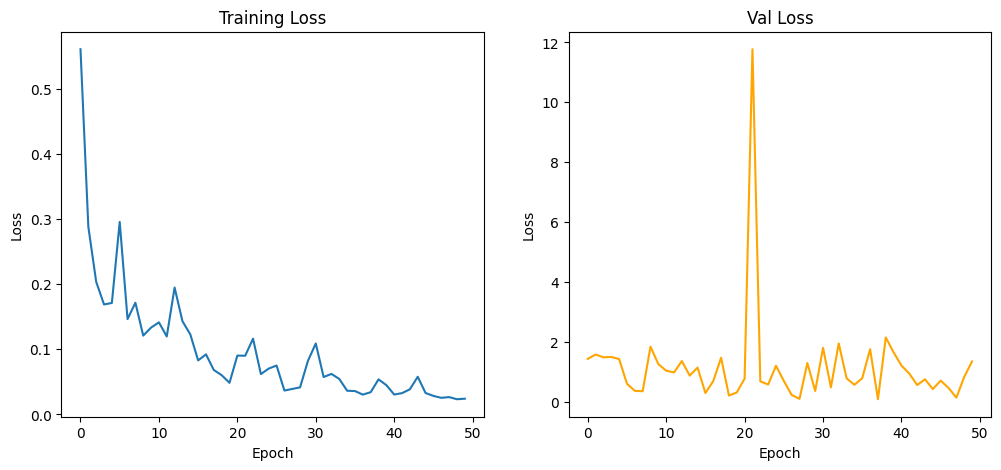

In [19]:
# Plotting the training and validating losses
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training losses
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Validating losses
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [20]:
# Evaluate the model
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.712511091393079
Test accuracy:  0.6909413854351687
